In [4]:
import sys

sys.path.append("/homes/gf332/compression-without-quantization/code")

import tensorflow.compat.v1 as tf
import tensorflow_compression as tfc
import tensorflow_probability as tfp
import tensorflow.contrib.eager as tfe
tfd = tfp.distributions
tfk = tf.keras
tfl = tf.keras.layers

from architectures import AnalysisTransform_1, SynthesisTransform_1, AnalysisTransform_2, \
SynthesisTransform_2, ProbabilisticLadderNetwork, VariationalAutoEncoder

from miracle import create_dataset, quantize_image

import matplotlib.pyplot as plt
import numpy as np

tf.enable_eager_execution()

In [2]:
data_path = "/scratch/gf332/datasets/miracle_image_compression/train"
patch_size = 256
batch_size = 8
preprocess_threads = 1
likelihood = "gaussian"
learn_gamma = True

model_dir = "/scratch/gf332/cwoq-models/pln-test"

# ------------------------------------------------------------------------
# Load Dataset
# ------------------------------------------------------------------------
train_dataset = create_dataset(data_path, 
                               patch_size, 
                               batch_size, 
                               preprocess_threads)

num_pixels = batch_size * patch_size ** 2

# ------------------------------------------------------------------------
# Create Model and optimizer
# ------------------------------------------------------------------------
model = ProbabilisticLadderNetwork(first_level_filters=196,
                                   second_level_filters=128,
                                   first_level_latent_channels=128,
                                   second_level_latent_channels=24,
                                   likelihood=likelihood,
                                   learn_gamma=learn_gamma)

# model = VariationalAutoEncoder(num_filters=128,
#                                num_latent_channels=128,
#                                likelihood=likelihood,
#                                learn_gamma=learn_gamma)
model(tf.ones((1, 256, 256, 3)))
# ------------------------------------------------------------------------
# Checkpoints
# ------------------------------------------------------------------------
latest = tf.train.latest_checkpoint(checkpoint_dir=model_dir)
tfe.Saver(model.trainable_variables).restore(latest)

W0820 16:40:46.272547 139847193896704 saver.py:795] Saver is deprecated, please switch to tf.train.Checkpoint or tf.keras.Model.save_weights for training checkpoints. When executing eagerly variables do not necessarily have unique names, and so the variable.name-based lookups Saver performs are error-prone.
W0820 16:40:46.273672 139847193896704 deprecation.py:323] From /scratch/gf332/compression_venv/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


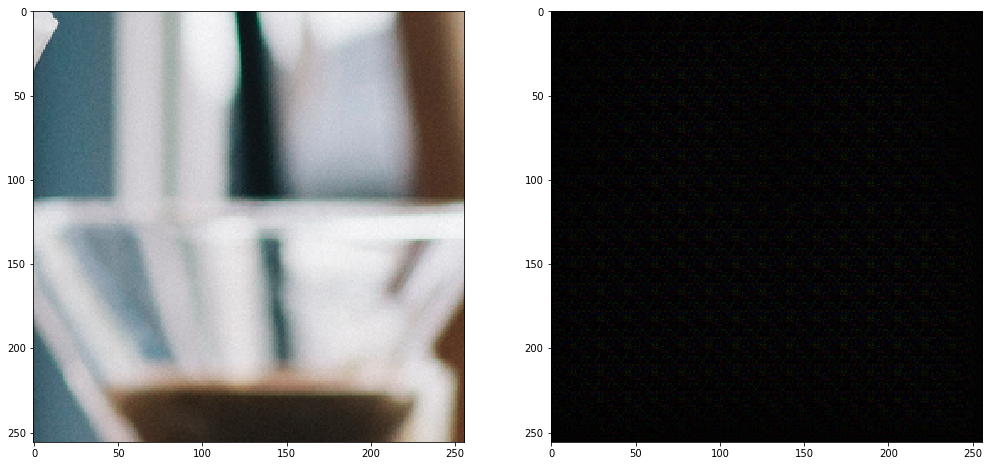

In [8]:
for batch in train_dataset.take(1):
    im = batch[3]

    plt.figure(figsize=(17, 8))
    plt.subplot(121)
    plt.imshow(im)

    rec = model(batch[3:4])
    
    plt.subplot(122)
    plt.imshow(quantize_image(rec[0]))